In [ ]:
#%%
!pip3 install albumentations


In [13]:
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm, trange


In [3]:
#%%
class carlaData(Dataset):
    def __init__(self,img_dir,transform = None):
        self.transforms = transform
        image_paths = [i+'/CameraRGB' for i in img_dir]
        seg_paths = [i+'/CameraSeg' for i in img_dir]
        self.images,self.masks = [],[]
        for i in image_paths:
            imgs = os.listdir(i)
            self.images.extend([i+'/'+img for img in imgs])
        for i in seg_paths:
            masks = os.listdir(i)
            self.masks.extend([i+'/'+mask for mask in masks])
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img = np.array(Image.open(self.images[index]))
        mask = np.array(Image.open(self.masks[index]))
        if self.transforms is not None:
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            mask = torch.max(mask,dim=2)[0]
        return img,mask
#%%


In [27]:
data_dir = ['archive' + '/data'+i+'/data'+i for i in ['A','B','C','D','E']]
#%%
t1 = A.Compose([
    A.Resize(128,128),
    A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])
#%%

def get_images(image_dir,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    data = carlaData(image_dir,transform = t1)
    train_size = int(0.8 * data.__len__())
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return train_batch,test_batch
#%%
train_batch,test_batch = get_images(data_dir,transform =t1,batch_size=1)
#%%
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//8, kernel_size = 1)
        self.key_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim//8, kernel_size = 1)
        self.value_conv = nn.Conv2d(in_channels = in_dim, out_channels = in_dim, kernel_size = 1)

        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        m_batchsize, C, width, height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim = -1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, width, height)

        out = self.gamma*out + x
        return out, attention


In [15]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)   
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
            
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    


In [21]:
#%%
device = "cuda" if torch.cuda.is_available() else "cpu"
class unet_model(nn.Module):
    def __init__(self, n_channels=64, n_classes=23, bilinear=False):
        super(unet_model, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(3, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.attention_1 = SelfAttention(64)
        self.attention_2 = SelfAttention(128)
        self.attention_3 = SelfAttention(256)
        self.attention_4 = SelfAttention(512)

        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        v1, _ = self.attention_4(x4)
        v2, _ = self.attention_3(x3)
        v3, _ = self.attention_2(x2)
        v4, _ = self.attention_1(x1)
        x = self.up1(x5, v1)
        x = self.up2(x, v2)
        x = self.up3(x, v3)
        x = self.up4(x, v4)
        logits = self.outc(x)
        return logits
#%%


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

#%%
model = unet_model().to(DEVICE)
LEARNING_RATE = 1e-4
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()
#%%
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
# %%
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x)),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
#%%
check_accuracy(train_batch, model)
#%%
check_accuracy(test_batch, model)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


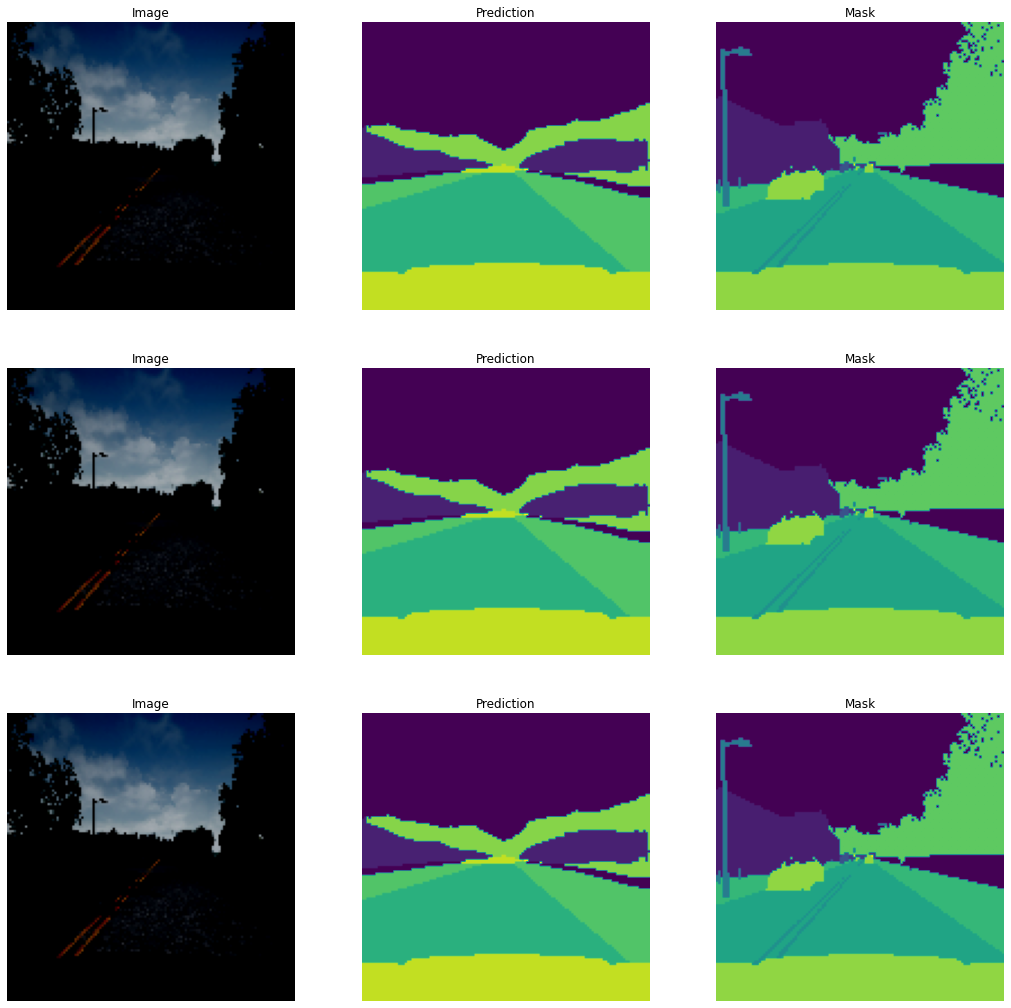

In [26]:
#%%
for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x)),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[0,:,:])
    mask2 = np.array(y[0,:,:])
    img3 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[0,:,:])
    mask3 = np.array(y[0,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break


